# Linear model try
V1.0  
This version is a first build-up of the whole system. 

V2.0  
This version added "central extraction", in which we only extract the central (0.3~0.9) part of videos for testing set.  
In this way, we try to avoid recognizing frames at the beginning and end of the videos that are not the target gesture as much as possible.  
尽可能避免前后识别出来但不是目标手势的帧

V3.0  
This version trys much to mimic the old model that reached best performance. 

V4.0  
hid dim reset to 5. 

V5.0  
try CNN

V7.0  
try CNN again after fixing the data problem. 

### Import Libs

In [1]:
import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader, random_split
import os
import numpy as np
import matplotlib.pyplot as plt
from torchview import draw_graph
import graphviz

from model_dataset import HandshapeDataset, DS_Tools, FixedHandshapeDict
from paths import *
from model_model import CNNHandshapePredictor
from model_configs import *
from utils import *
from recorder import *
from mio import mk

## Init Model

In [2]:
graphviz.set_jupyter_format('png')

'svg'

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.CrossEntropyLoss()
# criterion = nn.MSELoss()
model = CNNHandshapePredictor(
    input_dim=original_dim, 
    enc_lat_dims=enc_lat_dims, 
    hid_dim=hid_dim, 
    dec_lat_dims=dec_lat_dims, 
    output_dim=out_dim, 
    window_sizes=window_sizes
)
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

### Initialize model params

In [4]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.orthogonal_(m.weight)
        m.bias.data.fill_(0.01)

model.apply(init_weights)

CNNHandshapePredictor(
  (convs): ModuleList(
    (0): Sequential(
      (0): Conv1d(3, 5, kernel_size=(3,), stride=(1,))
      (1): MaxPool1d(kernel_size=19, stride=19, padding=0, dilation=1, ceil_mode=False)
      (2): ReLU()
    )
    (1): Sequential(
      (0): Conv1d(3, 5, kernel_size=(5,), stride=(1,))
      (1): MaxPool1d(kernel_size=17, stride=17, padding=0, dilation=1, ceil_mode=False)
      (2): ReLU()
    )
    (2): Sequential(
      (0): Conv1d(3, 5, kernel_size=(7,), stride=(1,))
      (1): MaxPool1d(kernel_size=15, stride=15, padding=0, dilation=1, ceil_mode=False)
      (2): ReLU()
    )
  )
  (encoder): Sequential(
    (0): Linear(in_features=15, out_features=5, bias=True)
    (1): Dropout(p=0.5, inplace=False)
  )
  (decoder): Sequential(
    (0): LinPack(
      (lin): Linear(in_features=5, out_features=64, bias=True)
      (relu): ReLU()
      (batch_norm): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): LinPack(
      (l

### Check number of params in model

In [5]:
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(params)

5053


## Prepare for logs

In [6]:
# Just for keeping records of training hists. 
ts = str(get_timestamp())
ts += "-cnn"
stop_epoch = "149"
save_subdir = os.path.join(model_save_dir, "{}/".format(ts))
mk(save_subdir)
save_trainhist_name = "train.hst"
save_valhist_name = "val.hst"
save_trainacc_name = "train_acc.hst"
save_valacc_name = "val_acc.hst"

valid_losses = LossRecorder(save_subdir + save_valhist_name)
train_losses = LossRecorder(save_subdir + save_trainhist_name)
train_accuracies = LossRecorder(save_subdir + save_trainacc_name)
valid_accuracies = LossRecorder(save_subdir + save_valacc_name)
# text_hist = HistRecorder(save_subdir + save_txt_name)

print("NOTE: {} is the series number this time. ".format(ts))

NOTE: 1113173024-cnn is the series number this time. 


### Switch for loading saved records

In [7]:
READ = False
# READ = True

if READ: 
    valid_losses.read()
    train_losses.read()
    train_accuracies.read()
    valid_accuracies.read()

    model_raw_name = f"{stop_epoch}"
    model_name = model_raw_name + ".pt"
    model_path = os.path.join(save_subdir, model_name)
    state = torch.load(model_path)
    model.load_state_dict(state)
    model.to(device)

## Dataset and Dataloader

### Data and Tag Paths

In [8]:
# data_path = os.path.join(data_dir, data_name + "_data.npz")
# tag_path = os.path.join(data_dir, data_name + "_tag.npz")

train_data_path = os.path.join(data_dir, train_name + "_data.npz")
train_tag_path = os.path.join(data_dir, train_name + "_tag.npz")

test_data_path = os.path.join(data_dir, test_mono_name + "_data.npz")
test_tag_path = os.path.join(data_dir, test_mono_name + "_tag.npz")

### Create Dataset

In [9]:
dictionary = FixedHandshapeDict()

ds = HandshapeDataset(train_data_path, train_tag_path, dictionary)
# valid_ds = HandshapeDataset(test_data_path, test_tag_path, dictionary)
if READ: 
    valid_ds_indices = DS_Tools.read_indices(os.path.join(save_subdir, "valid_ds_{}.pkl".format(ts)))
    all_indices = list(range(len(ds)))
    train_ds_indices = list(set(all_indices).difference(set(valid_ds_indices)))

    train_ds = torch.utils.data.Subset(ds, train_ds_indices)
    valid_ds = torch.utils.data.Subset(ds, valid_ds_indices)
else: 
    train_len = int(0.9 * len(ds))
    valid_len = len(ds) - train_len

    # Randomly split the dataset into train and validation sets
    train_ds, valid_ds = random_split(ds, [train_len, valid_len])
    DS_Tools.save_indices(os.path.join(save_subdir, "valid_ds_{}.pkl".format(ts)), valid_ds.indices)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=LOADER_WORKER)
train_num = len(train_loader.dataset)

valid_loader = DataLoader(valid_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=LOADER_WORKER)
valid_num = len(valid_loader.dataset)


### Check size of dataset

In [10]:
print(train_num, valid_num)

64435 7160


### Save model structure

In [11]:
model_graph = draw_graph(model, input_size=(BATCH_SIZE, length, original_dim), 
                         save_graph=True, filename=save_subdir + "model_plot")

## Training

### Define validation set cut range

In [12]:
# cut_range = (0.2, 0.9)
cut_range = None

In [13]:
BASE = 0
EPOCHS = 30

In [14]:
def train(): 
    best_valid_loss = 1000000
    best_valid_loss_epoch = 0
    for epoch in range(BASE, BASE + EPOCHS):
        model.train()
        train_loss = 0.
        train_num = len(train_loader)    # train_loader

        train_correct = 0   # for accuracy
        train_total = 0
        for idx, (x, tags) in enumerate(train_loader):
            optimizer.zero_grad()
            
            x = DS_Tools.cut_frames(x, cut_range=cut_range)
            tags = DS_Tools.cut_frames(tags, cut_range=cut_range)

            x = x.to(device)
            x = x.to(torch.float32)
            tags = tags.to(device)
            
            preds = model(x)

            loss = criterion(preds, tags)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

            predicted = torch.argmax(nn.Softmax(dim=1)(preds), dim=1)
            train_total += tags.size(0)
            train_correct += (predicted == tags).sum().item()

            draw_progress_bar(idx, train_num, title="Train")

        train_losses.append(train_loss / train_num)
        train_accuracies.append((100 * train_correct / train_total))
        # text_hist.print(f"※※※Training loss {train_loss / train_num: .3f}※※※")

        last_model_name = "{}.pt".format(epoch)
        torch.save(model.state_dict(), os.path.join(save_subdir, last_model_name))
        # text_hist.print("Training timepoint saved")

        model.eval()
        valid_loss = 0.
        valid_num = len(valid_loader)

        valid_correct = 0
        valid_total = 0
        for idx, (x, tags) in enumerate(valid_loader):
            x = DS_Tools.cut_frames(x, cut_range=cut_range)
            tags = DS_Tools.cut_frames(tags, cut_range=cut_range)

            x = x.to(device)
            x = x.to(torch.float32)
            tags = tags.to(device)
            preds = model(x)    # (B, C)

            loss = criterion(preds, tags)

            valid_loss += loss.item()


            predicted = torch.argmax(nn.Softmax(dim=1)(preds), dim=1)
            valid_total += tags.size(0)
            valid_correct += (predicted == tags).sum().item()

            draw_progress_bar(idx, valid_num, title="Valid")

        avg_valid_loss = valid_loss / valid_num
        valid_losses.append(valid_loss / valid_num)
        valid_accuracies.append((100 * valid_correct / valid_total))
        if avg_valid_loss < best_valid_loss: 
            best_valid_loss = avg_valid_loss
            best_valid_loss_epoch = epoch


        draw_learning_curve_and_accuracy(losses=(train_losses.get(), valid_losses.get(), best_valid_loss_epoch), 
                                         accs=(train_accuracies.get(), valid_accuracies.get()), 
                                         epoch=str(epoch))
        train_losses.save()
        valid_losses.save()

        train_accuracies.save()
        valid_accuracies.save()

        # text_hist.print(f"※※※Valid loss {valid_loss / valid_num: .3f}※※※")
        # text_hist.print(f"※※※Valid accuracy {(100 * valid_correct / valid_total): .3f} %※※※")

In [15]:
# train_accuracies.get()[644], valid_accuracies.get()[644]

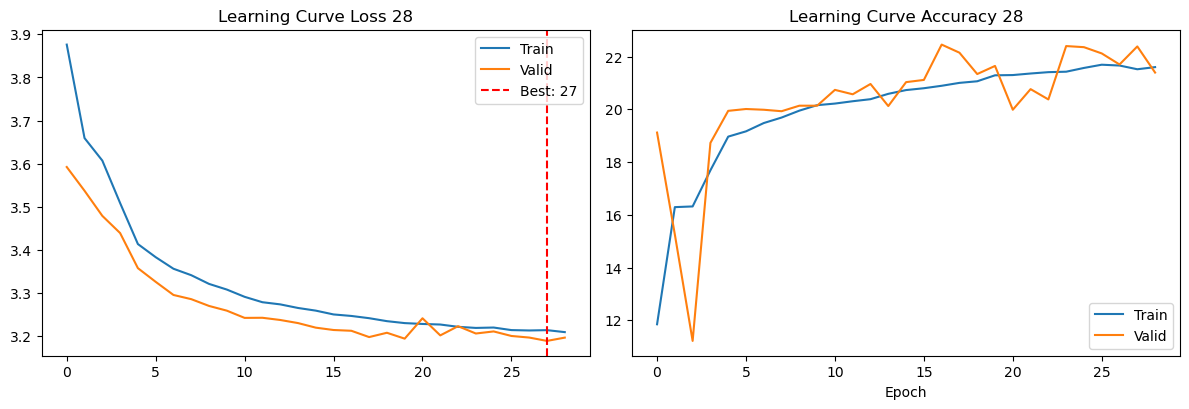

Train [======================================            ] 75%

KeyboardInterrupt: 

<Figure size 640x480 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

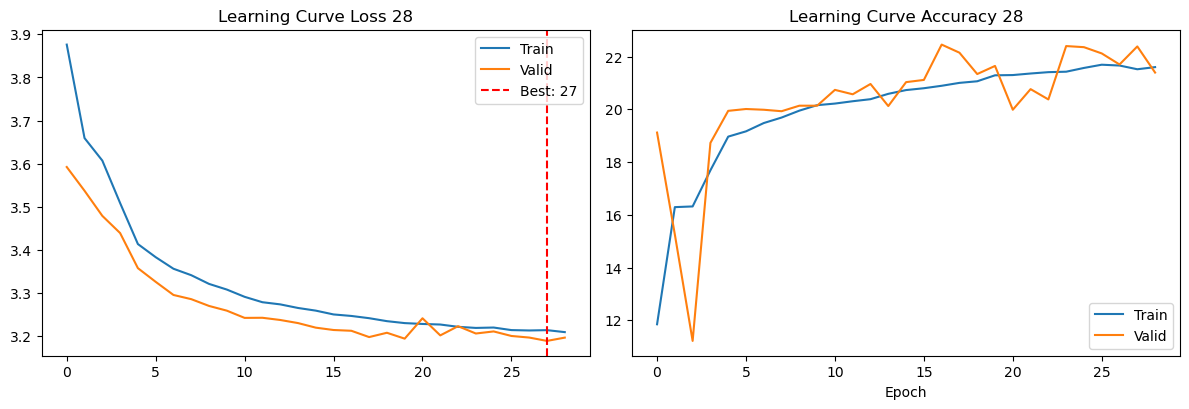

In [16]:
if __name__ == "__main__": 
    train()